# MNIST

Obiettivo: costruire un modello che sia in grado di riconoscere carattere numerico manoscritto.

paragonare modello dl senza preprocessing e modello costruito dopo preprocessing

## Step

Al fine di diminuire il numero di neuroni della rete e migliorare le prestazioni, si effettua del preprocessing.

- Importing data
- Preprocessing
  1. eliminazione rumore (filtro mediano)
  1. uniforming thickness
  1. resizing & centering
  1. fixing discontinuity (reconstructing ink hole)
  1. normalizing
- model

Cominciamo importando le librerie necessarie per il corretto funzionamento del codice (tensorflow, keras, matplotlib)

In [ ]:
%%capture
import os
import pandas as pd
import cv2
import tensorflow.keras as keras
import tensorflow as tf
import mnist
import numpy as np
import matplotlib.pyplot as plt
from   tensorflow.keras.models import Sequential
from   tensorflow.keras.layers import Dense

## No pre-processing
Addestro modello senza effettuare preprocessing

In [ ]:
# loading data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data(path = "mnist.npz")

# undestand data dimensions
print("Data dimensions:\n")
print("x_lrn:",x_train.shape)
print("x_tst:",x_test.shape)
print("y_lrn:",y_train.shape)
print("y_tst:",y_test.shape)

In [ ]:
# visualizzo un esempio di pattern
npat = 7
print("Ecco il pattern n.", npat)
print("Il valore atteso è: ", y_train[npat]);

img = x_train[npat];
plt.imshow(img, cmap = 'gray')
plt.show(block = False)

In [ ]:
# rendo categoriche le variabili di output
num_categories = 10
y_train = keras.utils.to_categorical(y_train,num_categories)
y_test = keras.utils.to_categorical(y_test, num_categories)

# visualizzo preview del pattern categorizzato
print("New categorical output pattern n.",npat,"=",y_train[npat])

In [ ]:
# normalizzo usando la funzione di keras
x_train = keras.utils.normalize(x_train, axis = 1)
x_test = keras.utils.normalize(x_test, axis = 1)

In [ ]:
# creo il modello
model = Sequential()

# flattening
model.add(keras.layers.Flatten(input_shape = (28,28)))

# aggiungo layer + input
model.add(Dense(units = 100, activation = 'relu', input_shape = (784,)))

# aggiungo uno strato nascosto
model.add(Dense(units = 2, activation = 'relu'))

# output layer
model.add(Dense(units = 10, activation = 'softmax'))

model.summary()

In [ ]:
# addestro il modello
model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs = 15, verbose = 1, validation_data = (x_test, y_test));

In [ ]:
# visualizzo tabella history dei risultati con pandas
pd.DataFrame(history.history)

In [ ]:
# crea funzione per visualizzare i risultati
def plot_results(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(5,5))
    plt.subplot(2,1,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')

    # summarize history for loss
    plt.subplot(2,1,2)
    plt.subplots_adjust(hspace = 0.5)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

# invoco funzione per visualizzare i risultati
plot_results(history)

In [ ]:
# Salvataggio del modello
model.save('4_mnist/models/np.mnist.model.h5')

## Importo le mie immagini

Creo funzione per salvare tutte le immagini di una cartella in un array e ridimensionarle.

In [ ]:
# definisci funzione 'importa_mie_immagini'
def importa_mie_immagini(cartella_immagini, nuova_dimensione):
    # inizializza l'array numpy per contenere tutte le immagini ridimensionate
    immagini = np.empty((0, *nuova_dimensione), dtype=np.uint8)

    # scorri tutti i file nella cartella specificata
    for nome_file in os.listdir(cartella_immagini):
        # carica l'immagine
        percorso_file = os.path.join(cartella_immagini, nome_file)
        img = cv2.imread(percorso_file, cv2.IMREAD_GRAYSCALE)

        # ridimensiona l'immagine
        img_ridimensionata = cv2.resize(img, nuova_dimensione)

        # aggiungi l'immagine all'array numpy
        immagini = np.vstack([immagini, np.expand_dims(img_ridimensionata, axis=0)])

    return immagini

# specifica il percorso della cartella contenente le immagini
cartella_immagini = "4_mnist/img/numbers"

# specifica le dimensioni desiderate
nuova_dimensione = (28, 28)

# carica le immagini
immagini = importa_mie_immagini(cartella_immagini, nuova_dimensione)

# stampa le dimensioni dell'array numpy contenente tutte le immagini ridimensionate
print(immagini.shape)

In [66]:
# carico modello salvato
model = keras.models.load_model('4_mnist/models/np.mnist.model.h5')

1/1 [==============================] - 0s 43ms/step


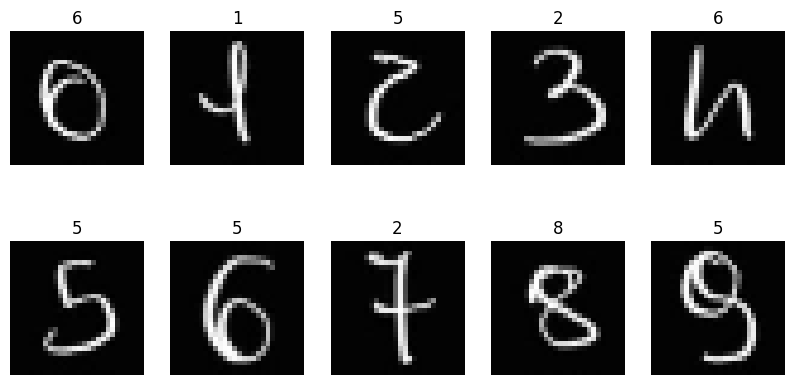

In [67]:
# applico modello alle mie immagini
predictions = model.predict(immagini)

plt.figure(figsize=(10, 5))
for i in range(0, immagini.shape[0]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(immagini[i], cmap = 'gray')
    plt.title(np.argmax(predictions[i]))
    plt.axis('off')
plt.show(block = False)

## Pre processing

Visualizziamo un'immagine del dataset di learning (per modificare il numero dell'immagine, modifica il valore della variabile `npat`)

In [97]:
# loading data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data(path = "mnist.npz")

# undestand data dimensions
print("Data dimensions:\n")
print("x_lrn:",x_train.shape)
print("x_tst:",x_test.shape)
print("y_lrn:",y_train.shape)
print("y_tst:",y_test.shape)

Data dimensions:

x_lrn: (60000, 28, 28)
x_tst: (10000, 28, 28)
y_lrn: (60000,)
y_tst: (10000,)


Ecco il pattern n. 7
Il valore atteso è:  3


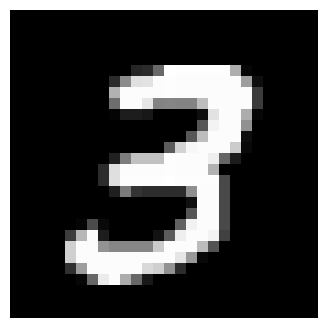

In [98]:
npat = 7
print("Ecco il pattern n.", npat)
print("Il valore atteso è: ", y_train[npat]);

img = x_train[npat];

# definisci funzione 'show_image' con le stesse proprietà del plot sotto
def show_image(img):
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
    plt.show(block = False)

# invoco funzione 'show_image'
show_image(img)

Da adesso in poi useremo una variabile temporanea `img` che conterrà l'immagine `x_train[npat]` in modo tale da non lavorare con l'intero array di immagini.

### Reducing noise

L'idea è quella di applicare un filtro mediano.

Utilizzeremo la libreria `OpenCV` (che importeremo con `import cv2`) dopo averla installata da terminale `pip install opencv-python`

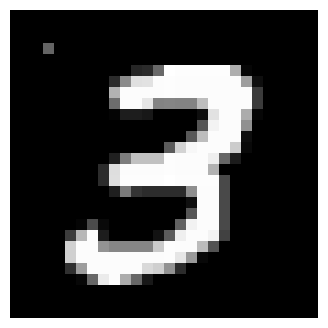

In [99]:
# add noise in pixel 3,3
img[3,3] = 100
x_train[npat,3,3] = 100

# preview
show_image(img)

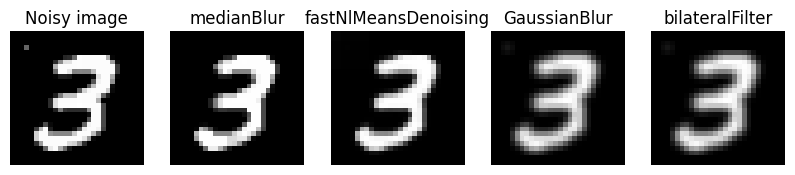

In [100]:
# using csv2 to remove noise
dn0 = cv2.medianBlur(img, 3)
dn1 = cv2.fastNlMeansDenoising(img, h=60, templateWindowSize=3, searchWindowSize=8)
dn2 = cv2.GaussianBlur(img, (3, 3), 1)
dn3 = cv2.bilateralFilter(img, 9, 70, 70)

denoised = [dn0, dn1, dn2, dn2]
titles = ["medianBlur","fastNlMeansDenoising", "GaussianBlur", "bilateralFilter"]

# plotting
plt.figure(figsize=(10, 5))
plt.subplot(1,5,1)
plt.title("Noisy image")
plt.imshow(img, cmap = 'gray')
plt.axis('off')

for i in range(len(denoised)):
    plt.subplot(1,5,i+2)
    plt.title(titles[i])
    plt.imshow(denoised[i], cmap = 'gray')
    plt.axis('off')
    
plt.show()

In [101]:
# scelgo metodo
img = dn0

# check
print("Il rumore è sparito?")
if img[3,3] == 0:
    print("sì, il pixel 3,3 ha valore 0")
else:
    print("no, il pixel 3,3 ha valore", img[3,3])


Il rumore è sparito?
sì, il pixel 3,3 ha valore 0


### Fix discontinuity

OpenCV's Closing is reverse of Opening, Dilation followed by Erosion. It is useful in closing small holes inside the foreground objects, or small black points on the object.

`closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)`

dove 

`kernel = np.ones((5,5),np.uint8)`

è la dimensione della finestra di azione del filtro.

[Click here](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html) for more info

Si tratta essenzialmente di un `dilate` seguito da `erode` per "coprire i buchi"

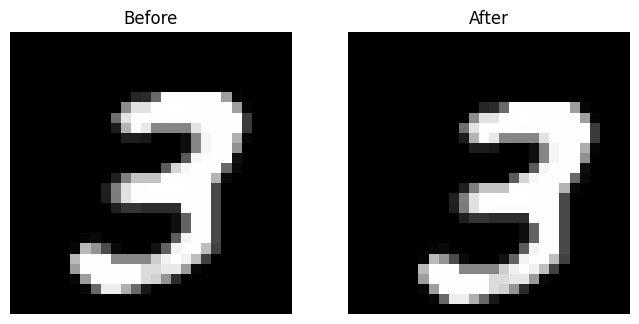

In [103]:
# pixel lato finestra
w = 2

# creo finestra
kernel = np.ones((w,w),np.uint8)

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.imshow(img, cmap = 'gray')
plt.title("Before")
plt.axis('off')

# rimuovo buchi
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

plt.subplot(1,2,2)
plt.imshow(img, cmap = 'gray')
plt.title("After")
plt.axis('off')
plt.show()

### Thickening

Lo strumento vincente sembra erosion di OpenCV ([leggi qui](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html#erosion))

La sintassi è:

```python
img = cv2.imread('j.png',0)
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(img,kernel,iterations = 1)
```

#### Riferimenti
-  https://stackoverflow.com/questions/56601130/how-to-reduce-the-thickness-of-the-contours
-  https://stackoverflow.com/questions/51133962/how-can-i-scale-a-thickness-of-a-character-in-image-using-python-opencv

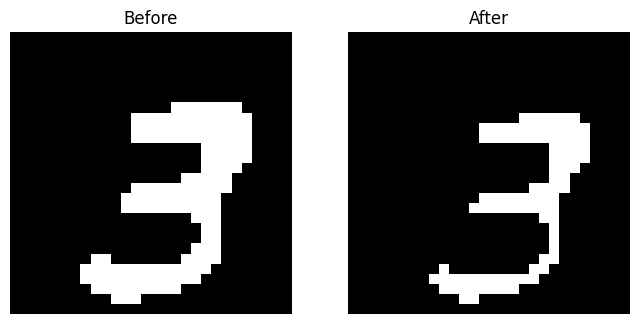

In [112]:
# plot before
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.imshow(img, cmap = 'gray')
plt.title("Before")
plt.axis('off')

# riduco spessore
erosion = cv2.erode(img,kernel,iterations = 1)

# plot after
plt.subplot(1,2,2)
plt.imshow(erosion, cmap = 'gray')
plt.title("After")
plt.axis('off')

# sovrascrivo immagine
img = erosion

### Binarizing

Esistono varie tecniche ([vedi qui](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html))

```python
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)
```

se non funzinoa, possiamo provare il metodo di Otzu:
```python
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
```

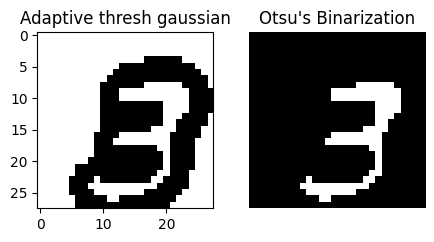

In [113]:
# adaptive thresh gaussian
atg = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,6)

# otsu
ret,ots = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plotting results
plt.figure(figsize=(5, 3))
plt.subplot(1,2,1)
plt.title("Adaptive thresh gaussian")
plt.imshow(atg, cmap = 'gray')
plt.subplot(1,2,2)
plt.title("Otsu's Binarization")
plt.imshow(ots, cmap = 'gray')
plt.axis('off')
plt.show()

In [114]:
# scelgo metodo
img = ots

### Resizing

focus to content

Riferimenti:
- https://stackoverflow.com/questions/74089678/remove-whitespace-of-a-image-python-opencv

Non funziona


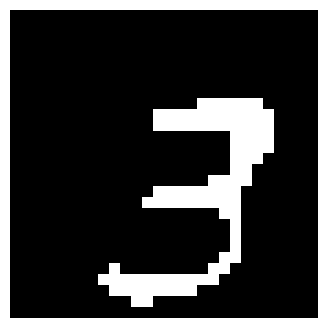

In [125]:
# define function
def focus_to_content(img):
    img_ = 255*(img < 128).astype(np.uint8) 
    coords = cv2.findNonZero(img_) # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
    
    rect = img[y:y+h, x:x+w] # Crop the image - note we do this on the original image
    rect_originalSized = cv2.resize(rect,(img.shape))
    return rect_originalSized

# apply function
test = focus_to_content(img)

# show
print("Non funziona")
show_image(test)

In [ ]:
# rendo categoriche le variabili di output
num_categories = 10
y_train = keras.utils.to_categorical(y_train,num_categories)
y_test = keras.utils.to_categorical(y_test, num_categories)

In [ ]:
print("New categorical output pattern n.",npat,"=",y_train[npat])

## Operazioni sull'array

In [93]:
# voglio applicare il filtro di denoising a tutto l'array
# ATTENZIONE: bisogna farlo anche per il test set

# Inizializza un nuovo array vuoto per le immagini filtrate
x_train_filtered = np.zeros_like(x_train)
x_test_filtered = np.zeros_like(x_test)

for i in range(len(x_train)):
    x_train_filtered[i] = cv2.fastNlMeansDenoising(x_train[i], h=60, templateWindowSize=3, searchWindowSize=8)
    
for i in range(len(x_test)):
    x_test_filtered[i] = cv2.fastNlMeansDenoising(x_test[i], h=60, templateWindowSize=3, searchWindowSize=8)

KeyboardInterrupt: 

In [ ]:
# plot filtered image
plt.imshow(x_train_filtered[npat], cmap = 'gray')
plt.show()

In [ ]:
plt.imshow(img, cmap = 'gray')
plt.title("Denoised")
plt.show()

In [ ]:
# inizializzo array vuoto
x_train_bin = np.zeros_like(x_train)
x_test_bin = np.zeros_like(x_test)

for i in range(len(x_train)):
    ret,img = cv2.threshold(x_train_erode[i],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    x_train_bin[i] = img

for i in range(len(x_test)):
    ret,img = cv2.threshold(x_test_erode[i],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    x_test_bin[i] = img

NameError: name 'x_train_bin' is not defined

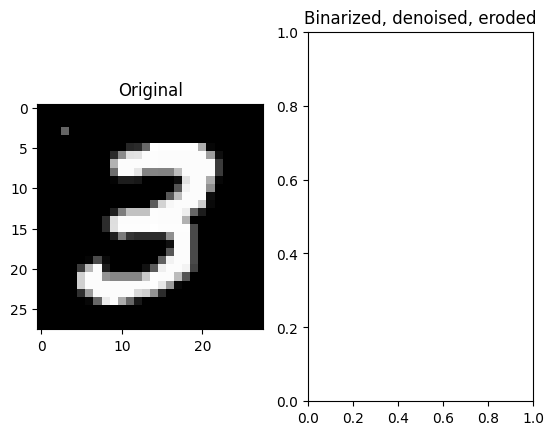

In [107]:
# plot filtered image
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(x_train[npat], cmap = 'gray')
plt.subplot(1,2,2)
plt.title("Binarized, denoised, eroded")
plt.imshow(x_train_bin[npat], cmap = 'gray')
plt.show()

In [ ]:
# applico erode all'array x_train_filtered

# test = cv2.erode(x_train_filtered, kernel, iterations = 1)

plt.imshow(test[npat], cmap = 'gray')
plt.show()

# non funziona bene

In [ ]:
# Inizializza un nuovo array vuoto per le immagini erode
x_train_erode = np.zeros_like(x_train)
x_test_erode = np.zeros_like(x_test)

# applico filtro erode all'array x_train_filtered
for i in range(len(x_train_filtered)):
    x_train_erode[i] = cv2.erode(x_train_filtered[i], kernel, iterations = 1)

for i in range(len(x_test)):
    x_test_erode[i] = cv2.erode(x_test_filtered[i], kernel, iterations = 1)

In [ ]:
plt.imshow(x_train_erode[npat], cmap = 'gray')
plt.show()

## Modello
Adesso creiamo il modello avente due layer di neuroni con funzione di attivazione relu e l'ultimo (output) softmax

In [ ]:
# creo il modello
model=Sequential()

# aggiungo layer + input
model.add(Dense(units=100,activation='relu',input_shape=(784,)))

# aggiungo uno strato nascosto
model.add(Dense(units=2,activation='relu'))

# output layer
model.add(Dense(units=10,activation='softmax'))
model.summary()

In [ ]:
# addestro il modello
model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs = 15, verbose = 1, validation_data = (x_test, y_test));

In [ ]:
# List all data in history
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Salvataggio del modello
model.save('4_mnist/models/pp.mnist.model.h5')
plt.show()